In [1]:
import numpy as np
import warnings
from utils import *
from calibrators import * 
import pickle
warnings.filterwarnings("ignore")

## Accuracy Series: 
### on each dataset-model we compute the average accuracy on 10 shuffles of it

In [7]:
#sklean models
models = ['CNN','RF','GB']
datasets = ['MNIST','GTSRB_RGB','SignLanguage','Fashion','CIFAR_RGB']
acc_lst = []
for dataset in datasets:
    for model in models:
        serie = calculate_avarege_acc(model,dataset)
        acc_lst.append(serie)
pd.concat(acc_lst, axis=0,names=['Accuracy'])

Computing accuracy of CNN-MNIST..
Computing accuracy of RF-MNIST..
Computing accuracy of GB-MNIST..
Computing accuracy of CNN-GTSRB_RGB..
Computing accuracy of RF-GTSRB_RGB..
Computing accuracy of GB-GTSRB_RGB..
Computing accuracy of CNN-SignLanguage..
Computing accuracy of RF-SignLanguage..
Computing accuracy of GB-SignLanguage..
Computing accuracy of CNN-Fashion..
Computing accuracy of RF-Fashion..
Computing accuracy of GB-Fashion..
Computing accuracy of CNN-CIFAR_RGB..
Computing accuracy of RF-CIFAR_RGB..
Computing accuracy of GB-CIFAR_RGB..


CNN-MNIST           0.990157
RF-MNIST            0.965964
GB-MNIST            0.968300
CNN-GTSRB_RGB       0.966850
RF-GTSRB_RGB        0.975357
GB-GTSRB_RGB        0.841127
CNN-SignLanguage    0.998527
RF-SignLanguage     0.994903
GB-SignLanguage     0.978862
CNN-Fashion         0.897221
RF-Fashion          0.877793
GB-Fashion          0.885064
CNN-CIFAR_RGB       0.669542
RF-CIFAR_RGB        0.467625
GB-CIFAR_RGB        0.447675
dtype: float64

## ECE tables:

#### pytorch models:

In [9]:
#load all ece's
calib_methods = ['base', 'TSCalibrator', 'EnsembleTSCalibrator', 'HBCalibrator', 'SBCCalibrator', 'StabilityCalibrator','SepCalibrator', 'stab->SBC-Calibrator']
datasets = ['MNIST','GTSRB_RGB','SignLanguage','Fashion','CIFAR_RGB']
series = []
d = {dataset:[] for dataset in datasets}
for dataset in datasets:
    ecesSpecificDataset = []
    for shuffle in range(10):
        PATH_ece = f'./{dataset}/{shuffle}/pytorch/ECEs.npy'
        ecesSpecificDataset.append(np.load(PATH_ece,allow_pickle=True).item())
    
    ECEs = np.array([list(dic.values()) for dic in ecesSpecificDataset]) 
    conf_interval = np.apply_along_axis(mean_confidence_interval_str, 0, ECEs)
    calib_methods = list(ecesSpecificDataset[0].keys())
    prep_df_mnist = {calib:val for val, calib in zip(conf_interval, calib_methods)}
    serie = pd.DataFrame.from_dict(prep_df_mnist, orient = 'index', columns=[f'{dataset}-CNN'])
    series.append(serie)

In [10]:
df = pd.concat(series, axis=1)
df = df.T.drop(columns=['IsotonicCalibrator','PlattCalibrator'])
df = df[['StabilityCalibrator','SeperationCalibrator','base','TSCalibrator','EnsembleTSCalibrator','SBCCalibrator','HBCalibrator']]
df.style.apply(color_max, axis=1)

,StabilityCalibrator,SeperationCalibrator,base,TSCalibrator,EnsembleTSCalibrator,SBCCalibrator,HBCalibrator
MNIST-CNN,0.0019+-0.0004,0.0019+-0.0004,0.0065+-0.0009,0.0029+-0.0006,0.0027+-0.0005,0.0871+-0.0083,0.0049+-0.0009
GTSRB_RGB-CNN,0.0040+-0.0010,0.0038+-0.0007,0.0136+-0.0035,0.0111+-0.0040,0.0099+-0.0041,0.2844+-0.0208,0.0088+-0.0032
SignLanguage-CNN,0.0001+-0.0001,0.0001+-0.0001,0.0026+-0.0008,0.0025+-0.0009,0.0024+-0.0009,0.1783+-0.0090,0.0022+-0.0012
Fashion-CNN,0.0079+-0.0013,0.0076+-0.0013,0.0787+-0.0026,0.0084+-0.0011,0.0088+-0.0015,0.0733+-0.0051,0.0193+-0.0020
CIFAR_RGB-CNN,0.0127+-0.0019,0.0120+-0.0015,0.2379+-0.0025,0.0516+-0.0022,0.0516+-0.0043,0.0357+-0.0040,0.0599+-0.0026


#### sklearn models:

In [4]:
Series = []
datasets = ['MNIST','GTSRB_RGB','SignLanguage','Fashion','CIFAR_RGB']
models = ['RF','GB']
for dataset_name in datasets:
    for model_name in models:
        ECEs = []
        for shuffle_num in range(10):
            print(f'calculating {dataset_name}-{model_name}-{shuffle_num} ece....')
            ece = {}

            #load model
            model_info = load_shuffle(dataset_name, model_name, shuffle_num, isCalibrate=False)
            model_dir =  f'{dataset_name}/{shuffle_num}/model/model_{dataset_name}_{model_name}.sav'
            model = pickle.load(open(model_dir, 'rb'))

            # compute ece's
            #Base
            idCal = IdentityCalibrator()
            idCal.fit(model_info.all_predictions_val ,model_info.y_pred_val==model_info.data.y_val)
            ece['Base'] = idCal.ECE(model_info.all_predictions_test, model_info.y_pred_test, model_info.data.y_test)

            #Isotonic_sklearn
            ece['SKlearn_calibrator_isotonic'] = SKlearn_calibrator(model_info.data,'isotonic',model).fit().ECE()

            # #iso_self_imp
            # isoCal = IsotonicCalibrator()
            # isoCal.fit(model_info.all_predictions_val ,model_info.y_pred_val==model_info.data.y_val)
            # ece['IsotonicCalibrator'] = isoCal.ECE(model_info.all_predictions_test, model_info.y_pred_test, model_info.data.y_test)

            #sklearn platt
            ece['SKlearn_calibrator_platt'] = SKlearn_calibrator(model_info.data,'sigmoid',model).fit().ECE()

#             #plat_self_imp
#             platCal = PlattCalibrator()
#             platCal.fit(model_info.all_predictions_val ,model_info.y_pred_val==model_info.data.y_val)
#             ece['PlattCalibrator'] = platCal.ECE(model_info.all_predictions_test, model_info.y_pred_test, model_info.data.y_test)
 
            #stab
            stabCal = StabilityCalibrator()
            stabCal.fit(model_info.stability_val ,model_info.y_pred_val==model_info.data.y_val)
            ece['StabilityCalibrator'] = stabCal.ECE(model_info.stability_test, model_info.y_pred_test, model_info.data.y_test)

            #Sep
            sepCal = SeparationCalibrator()
            sepCal.fit(model_info.sep_val ,model_info.y_pred_val==model_info.data.y_val)
            ece['SeparationCalibrator'] = sepCal.ECE(model_info.sep_test, model_info.y_pred_test, model_info.data.y_test)

            # HB_toplabel
            HBcali = HBCalibrator()
            HBcali.fit(model_info.all_predictions_val, model_info.data.y_val + 1)
            prob_HB = HBcali.calibrate(model_info.all_predictions_test)
            ece['HBCalibrator'] = ECE_calc(prob_HB, model_info.y_pred_test, model_info.data.y_test, bins=15)

            #SBC
            SBCcali = SBCCalibrator()
            SBCcali.fit(model_info.all_predictions_val, model_info.data.y_val)
            SBC_probs_test = SBCcali.calibrate(model_info.all_predictions_test)
            y_SBC_test = np.argmax(SBC_probs_test,axis=1)
            ece['SBCCalibrator'] = ECE_calc(SBC_probs_test, y_SBC_test, model_info.data.y_test, bins=15)

            PATH = f'./{dataset_name}/{shuffle_num}/{model_name}/ece.npy'
            # np.save(PATH,ece)
            
            
            ECEs.append(ece)
            
            
        values = np.array([list(dic.values()) for dic in ECEs]) 
        conf_interval = np.apply_along_axis(mean_confidence_interval_str, 0, values)
        calib_methods = list(ece.keys())
        prep_df_mnist = {calib:val for val, calib in zip(conf_interval, calib_methods)}
        series = pd.DataFrame.from_dict(prep_df_mnist, orient = 'index', columns=[f'{dataset_name}-{model_name}'])
        Series.append(series.T)

calculating MNIST-RF-0 ece....
calculating MNIST-RF-1 ece....
calculating MNIST-RF-2 ece....
calculating MNIST-RF-3 ece....
calculating MNIST-RF-4 ece....
calculating MNIST-RF-5 ece....
calculating MNIST-RF-6 ece....
calculating MNIST-RF-7 ece....
calculating MNIST-RF-8 ece....
calculating MNIST-RF-9 ece....
calculating MNIST-GB-0 ece....
calculating MNIST-GB-1 ece....
calculating MNIST-GB-2 ece....
calculating MNIST-GB-3 ece....
calculating MNIST-GB-4 ece....
calculating MNIST-GB-5 ece....
calculating MNIST-GB-6 ece....
calculating MNIST-GB-7 ece....
calculating MNIST-GB-8 ece....
calculating MNIST-GB-9 ece....
calculating GTSRB_RGB-RF-0 ece....
Predictions for class 1 not recalibrated since fewer than 50 calibration points were predicted as class 1.
Predictions for class 33 not recalibrated since fewer than 50 calibration points were predicted as class 33.
calculating GTSRB_RGB-RF-1 ece....
Predictions for class 1 not recalibrated since fewer than 50 calibration points were predicted

In [19]:
df_comparison = pd.concat(Series)[['StabilityCalibrator', 'SeparationCalibrator','Base', 'SKlearn_calibrator_isotonic', 'SKlearn_calibrator_platt', 'HBCalibrator', 'SBCCalibrator']]
df_comparison.style.apply(color_max, axis=1)

,StabilityCalibrator,SeparationCalibrator,Base,SKlearn_calibrator_isotonic,SKlearn_calibrator_platt,HBCalibrator,SBCCalibrator
MNIST-RF,0.0039+-0.0006,0.0040+-0.0006,0.1629+-0.0016,0.0090+-0.0012,0.0148+-0.0007,0.0052+-0.0004,0.0366+-0.0038
MNIST-GB,0.0036+-0.0007,0.0035+-0.0009,0.0170+-0.0010,0.0174+-0.0015,0.0194+-0.0013,0.0048+-0.0008,0.0823+-0.0024
GTSRB_RGB-RF,0.0037+-0.0004,0.0036+-0.0007,0.3434+-0.0019,0.0257+-0.0013,0.0427+-0.0014,0.0080+-0.0015,0.1371+-0.0038
GTSRB_RGB-GB,0.0065+-0.0011,0.0067+-0.0013,0.0592+-0.0021,0.0996+-0.0030,0.2025+-0.0217,0.0134+-0.0024,0.3108+-0.0043
SignLanguage-RF,0.0008+-0.0002,0.0009+-0.0003,0.2536+-0.0015,0.0039+-0.0006,0.0174+-0.0008,0.0019+-0.0006,0.1688+-0.0066
SignLanguage-GB,0.0008+-0.0003,0.0008+-0.0002,0.0059+-0.0010,0.0405+-0.0018,0.0596+-0.0017,0.0047+-0.0004,0.3097+-0.0017
Fashion-RF,0.0074+-0.0016,0.0079+-0.0010,0.0918+-0.0014,0.0091+-0.0011,0.0374+-0.0012,0.0105+-0.0015,0.0345+-0.0031
Fashion-GB,0.0073+-0.0013,0.0073+-0.0008,0.0245+-0.0023,0.0380+-0.0020,0.0571+-0.0391,0.0105+-0.0014,0.0390+-0.0046
CIFAR_RGB-RF,0.0115+-0.0024,0.0119+-0.0023,0.1729+-0.0029,0.0325+-0.0028,0.0459+-0.0024,0.0254+-0.0036,0.0299+-0.0026
CIFAR_RGB-GB,0.0125+-0.0021,0.0131+-0.0016,0.0366+-0.0027,0.0757+-0.0025,0.0839+-0.0018,0.0282+-0.0022,0.0270+-0.0034


## An illustration of the inputs to the fitting function(blue and red dots), and the functions fitted by Sigmoid(black line) and isotonic regression (green line)

In [3]:
model_info = load_shuffle(dataset_name='GTSRB_RGB',model_name='GB',shuffle_num=0)

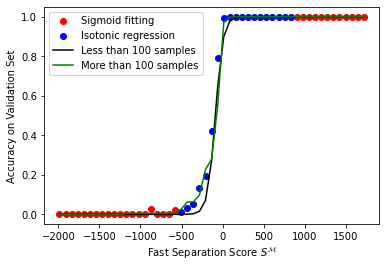

In [4]:
plot_fitting_function(model_info,n_bins=50)

In [5]:
model_info = load_shuffle(dataset_name='MNIST',model_name='RF',shuffle_num=0)

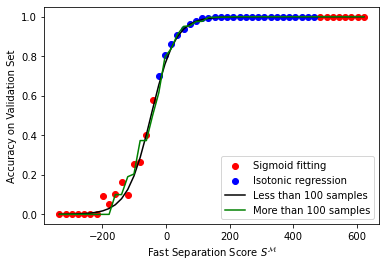

In [6]:
plot_fitting_function(model_info,n_bins=50)